In [33]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
import chainer
from chainer import Chain, optimizers, training
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
from sklearn.datasets import fetch_mldata

In [34]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "chainer", "matplotlib", "scikit-learn"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
chainer 2.0.2
matplotlib 2.0.2
scikit-learn 0.18.2


In [35]:
# 畳み込みニューラルネットワークでMNIST画像分類 ver. classifierクラス, trainingクラス

In [38]:
# モデルクラス定義

class CNN(Chain):
    def __init__(self):
        # クラスの初期化
        super(CNN, self).__init__(            
            conv1 = L.Convolution2D(1, 20, 5), # フィルター5
            conv2 = L.Convolution2D(20, 50, 5), # フィルター5
            l1 = L.Linear(800, 500),
            l2 = L.Linear(500, 500),
            l3 = L.Linear(500, 10, initialW=np.zeros((10, 500), dtype=np.float32))
        )
 
    def __call__(self, x):
        # 順伝播の計算を行う関数
        # :param x: 入力値
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        y = self.l3(h)
        return y

In [39]:
# 学習

EPOCH_NUM = 5
BATCH_SIZE = 1000
 
# 教師データ
mnist = fetch_mldata('MNIST original', data_home='.')
mnist.data = mnist.data.astype(np.float32) # 画像データ　784*70000 [[0-255, 0-255, ...], [0-255, 0-255, ...], ... ]
mnist.data /= 255 # 0-1に正規化する
mnist.target = mnist.target.astype(np.int32) # ラベルデータ70000

# 教師データを変換
dataset = []
for x, t in zip(mnist.data, mnist.target):
    dataset.append((x.reshape(1, 28, 28), t))
N = len(dataset)

# モデルの定義
model = L.Classifier(CNN())
optimizer = optimizers.Adam()
optimizer.setup(model)

# 学習開始
print("Train")
train, test = chainer.datasets.split_dataset_random(dataset, N-10000) # 60000件を学習用、10000件をテスト用
train_iter = chainer.iterators.SerialIterator(train, BATCH_SIZE)
test_iter = chainer.iterators.SerialIterator(test, BATCH_SIZE, repeat=False, shuffle=False)
updater = training.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (EPOCH_NUM, "epoch"), out="result")
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport( ["epoch", "main/loss", "validation/main/loss", "main/accuracy", "validation/main/accuracy", "elapsed_time"])) # エポック、学習損失、テスト損失、学習正解率、テスト正解率、経過時間
#trainer.extend(extensions.ProgressBar()) # プログレスバー出力
trainer.run()

Train
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.650315    0.183615              0.8102         0.9468                    119.811       
2           0.127514    0.0828921             0.960917       0.9764                    242.089       
3           0.0724181   0.0577342             0.978283       0.9823                    364.334       
4           0.0522166   0.0483831             0.983333       0.9848                    485.452       
5           0.0431929   0.0500313             0.9869         0.9852                    606.6         



Predict


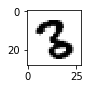

y:	3



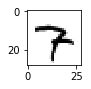

y:	7



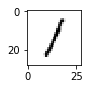

y:	1



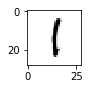

y:	1



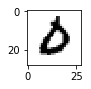

y:	0



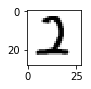

y:	2



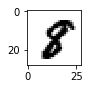

y:	8



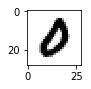

y:	0



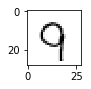

y:	9



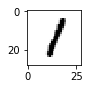

y:	1



In [42]:
# 予測

print("\nPredict")
def predict(model, x):
    y = np.argmax(model.predictor(x=np.array([x], dtype="float32")).data)
    plt.figure(figsize=(1, 1))
    plt.imshow(x[0], cmap=cm.gray_r)
    plt.show()
    print("y:\t{}\n".format(y))

idx = np.random.choice(70000, 10)
for i in idx:
    predict(model, dataset[i][0])